In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import h5py

In [2]:
file = '/Users/straniero/Documents/Dphil/SPS_TMCI/data/SPS.BQHT_MD4_20181108_222234.h5' # original, good data, T =1000
#file = '/Users/straniero/Documents/Dphil/SPS_TMCI/data/SPS.BQHT_MD4_20181108_215219.h5'
#file = '/Users/straniero/Documents/Dphil/SPS_TMCI/data/SPS.BQHT_MD2_20181026_131253.h5' # good data, T=10000
#
#file='/Users/straniero/Documents/Dphil/SPS_TMCI/data/SPS.BQHT_MD2_20181026_100152.h5'.  #no peaks, just noise

In [3]:
def print_structure(name, obj):
    print(name)

with h5py.File(file, 'r') as f:
    f.visititems(print_structure)


horizontal
horizontal/delta
horizontal/sigma
vertical
vertical/delta


In [4]:
# Open the file in read mode
with h5py.File(file, 'r') as f:
    # List all groups
    #print("Keys:", list(f.keys()))
    
    # Access a dataset
    vert_delta = f['vertical/delta'][:]   
    horiz_delta = f['horizontal/delta'][:]
    horiz_sigma = f['horizontal/sigma'][:]


In [5]:
total_l = len(vert_delta)

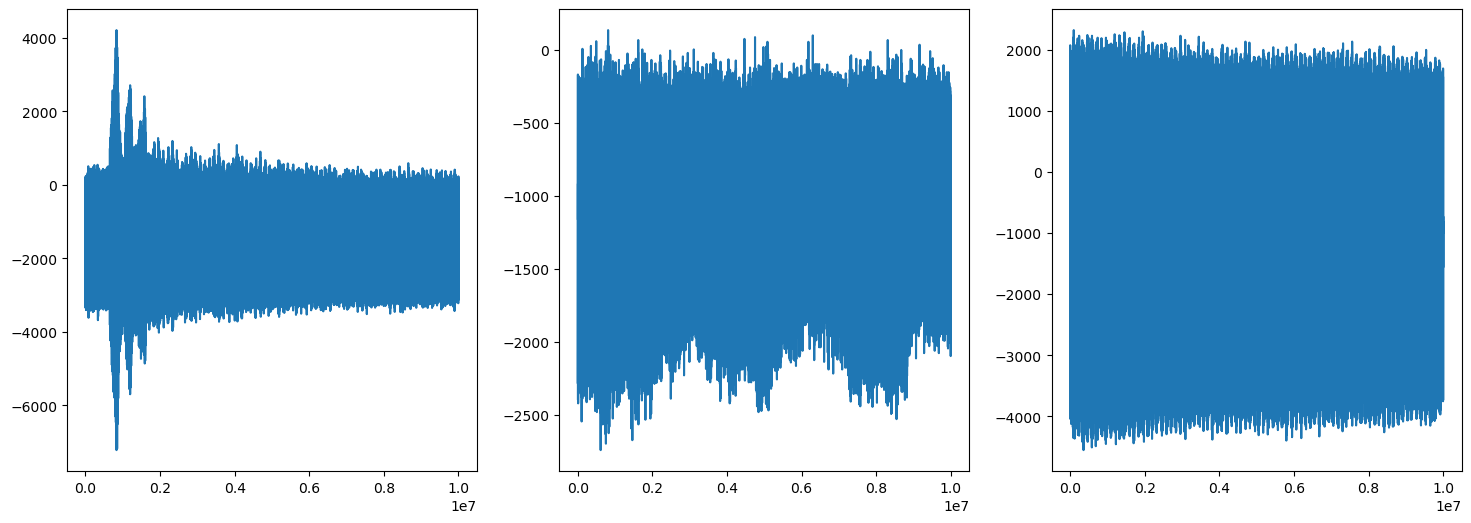

In [6]:
x = np.linspace(0, total_l, total_l)


fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize =(18,6))

ax1.plot(x,vert_delta)
ax2.plot(x,horiz_delta)
ax3.plot(x,horiz_sigma)



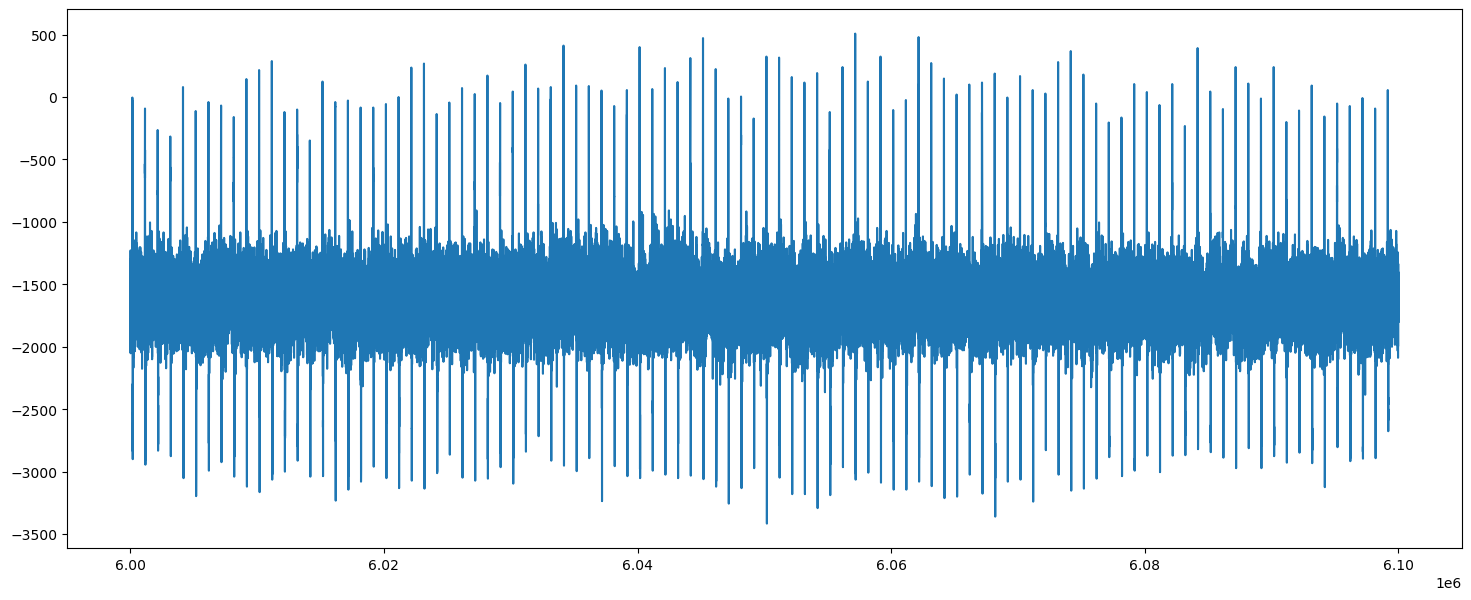

In [7]:
a = int(6e6)
plt.figure(figsize=(18,7))
plt.plot(x[a:a+100000],vert_delta[a:a+100000])

In [8]:

vert_delta_split = np.empty((10000,1000))
for i in range(10000):
    vert_delta_split[i,:] = vert_delta[i*1000:(i+1)*1000]

hor_delta_split = np.empty((10000,1000))
for i in range(10000):
    hor_delta_split[i,:] = horiz_delta[i*1000:(i+1)*1000]   

hor_sigma_split = np.empty((10000,1000))
for i in range(10000):
    hor_sigma_split[i,:] = horiz_sigma[i*1000:(i+1)*1000]

## Normalise signal over kick

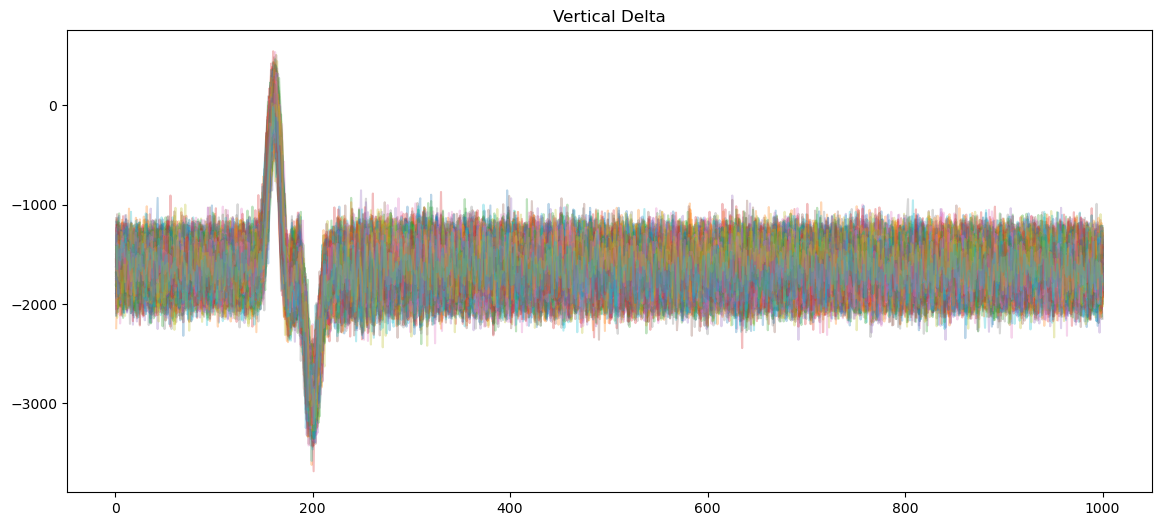

In [9]:
x3= np.linspace(1,1000,1000)
plt.figure(figsize=(14,6))
plt.title("Vertical Delta")
for i in range(500):
    plt.plot(x3[:],vert_delta_split[i,:], alpha=0.3)

In [10]:
#find maxs & mins indeces of unperturbed signal
maxs_indices = []
mins_indices = []
for i in range(500):
    bunch = vert_delta_split[i,:]
    maxs_indices.append([np.argmax(bunch),np.max(bunch)])
    mins_indices.append([np.argmin(bunch),np.max(bunch)])   

In [11]:
#Baseline fit guess
vertical_delta_b4_kick_split = vert_delta_split[0:500,:]

gaussian_FWHM = 12
sigma = gaussian_FWHM / (2 * np.sqrt(2 * np.log(2)))  # Convert FWHM to standard deviation
centre_max = 160
centre_min = 200
mean = np.mean(vertical_delta_b4_kick_split)
amplitude = np.max(vertical_delta_b4_kick_split) - mean
min_amplitude = mean - np.min(vertical_delta_b4_kick_split)


In [12]:
emulated = np.ones(1000)*mean
emulated[centre_max-3*int(sigma):centre_max+3*int(sigma)] += amplitude * np.exp(-0.5 * ((np.arange(centre_max-3*int(sigma), centre_max+3*int(sigma)) - centre_max) / sigma) ** 2)
emulated[centre_min-3*int(sigma):centre_min+3*int(sigma)] -= min_amplitude * np.exp(-0.5 * ((np.arange(centre_min-3*int(sigma), centre_min+3*int(sigma)) - centre_min) / sigma) ** 2)


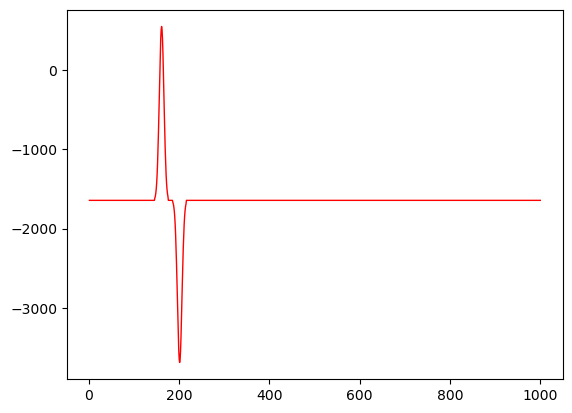

In [13]:

plt.plot(x3, emulated, color='red', linewidth=1)
plt.show()

In [14]:
##Offset
offset_vert_delta_split = np.empty((10000,1000))
for i in range(10000):
    offset_vert_delta_split[i,:] = vert_delta_split[i,:] - emulated

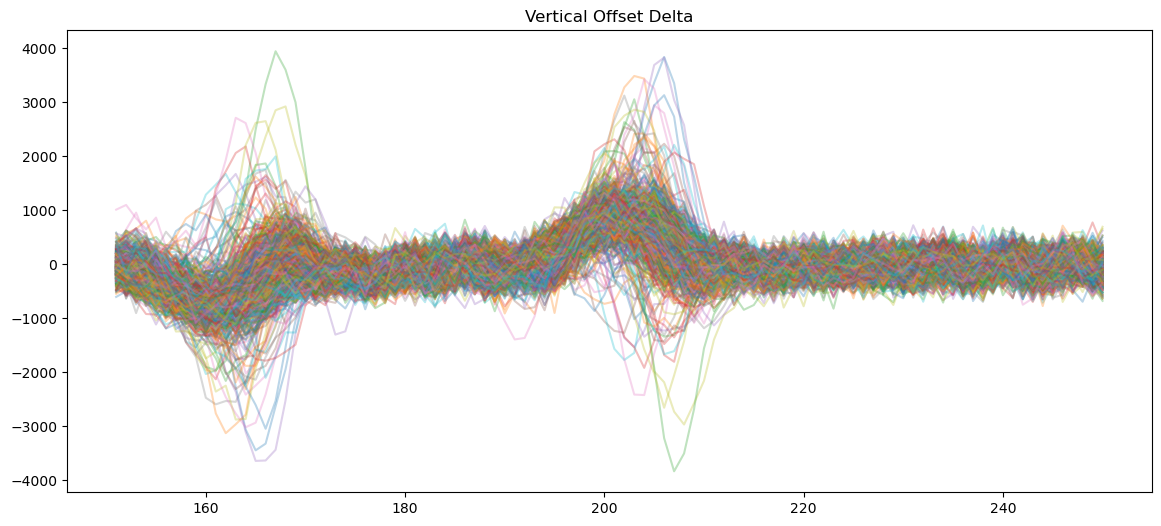

In [15]:
x3= np.linspace(1,1000,1000)
plt.figure(figsize=(14,6))
plt.title("Vertical Offset Delta")
for i in range(1000):
    plt.plot(x3[150:250],offset_vert_delta_split[i*10,150:250], alpha=0.3)

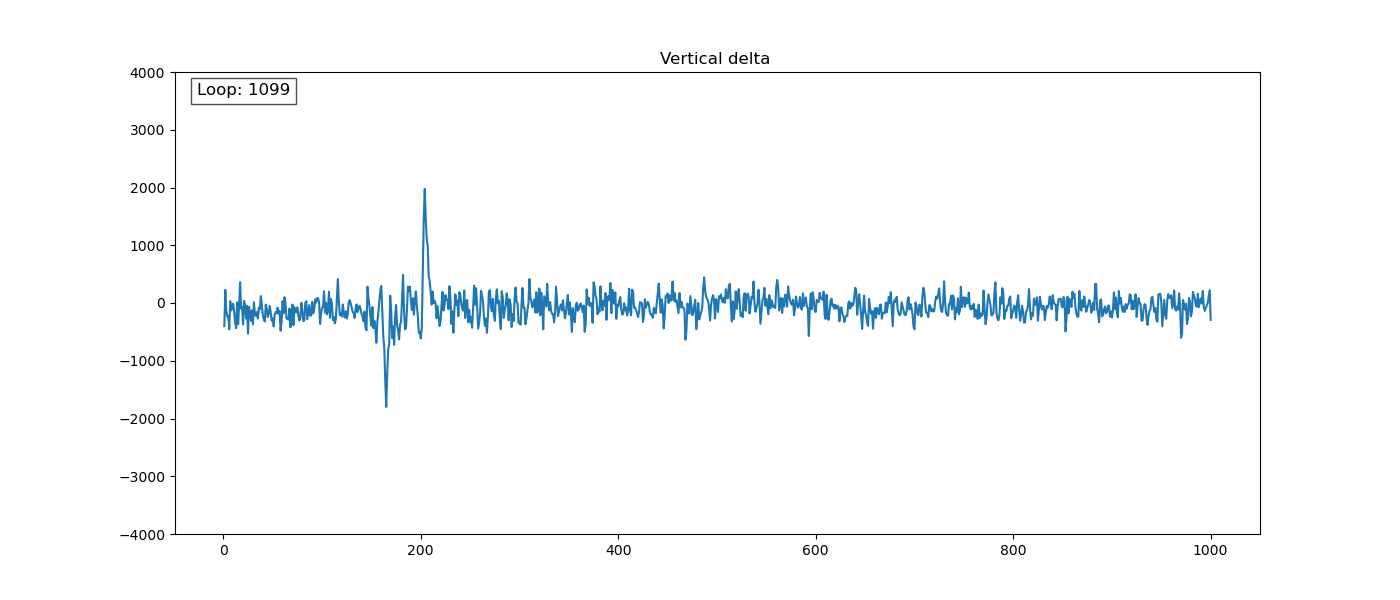

In [24]:

import matplotlib.animation as animation
%matplotlib ipympl

fig2, ax = plt.subplots(figsize=(14, 6))
graph, = ax.plot(x3, offset_vert_delta_split[0, :])
ax.set_title("Vertical delta ")
# Add a text box to display the frame number
frame_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12,
                     bbox=dict(facecolor='white', alpha=0.7))
#Set axes limits
ax.set_ylim(-4000, 4000)
def update(frame):
    graph.set_ydata(offset_vert_delta_split[frame, :])
    frame_text.set_text(f'Loop: {frame}')
    return graph, frame_text

ani = animation.FuncAnimation(fig2, update, frames=range(620,1100), blit=False, interval=50, repeat=False)
ani.save('vertical_sigma_evolution.mp4', writer='ffmpeg', fps=20)


## Peak tops evolution

In [17]:
tops = np.zeros((1,2))
offset_vert_delta = np.empty(int(1e7))
for i in range(10000):
    offset_vert_delta[i*1000:(i+1)*1000]= offset_vert_delta_split[i,:]


for id,p in enumerate(offset_vert_delta[int(6e5):int(7e6)]):
    if p> 1300:
        adding = np.ones((1,2))
        adding[0,0]=id+int(6e5)
        adding[0,1]=p
        tops = np.append(tops, adding, axis=0)



In [18]:
len(tops)

5494

In [19]:
#write the previous cell as a function

def refine_peaks(tops, threshold=500):
    tops = np.asarray(tops)
    tops_refined = []

    i = 0
    while i < len(tops):
        # start with current peak
        current_peak = tops[i]

        # check if next peak is within threshold samples
        if i < len(tops) - 1 and (tops[i+1,0] - tops[i,0] < threshold):
            # pick the higher one
            if tops[i,1] >= tops[i+1,1]:
                adding = current_peak
            else:
                adding = tops[i+1]
            i += 2        # skip the next one since it's handled
        else:
            # keep current peak as is
            adding = current_peak
            i += 1

        tops_refined.append(adding)

    tops_refined = np.vstack(tops_refined)
    return tops_refined

In [20]:
tops_copy = tops.copy()
for i in range(35):
    tops_refined = refine_peaks(tops_copy, threshold=500)
    if len(tops_refined) == len(tops_copy):
        break
    else:
        tops_copy = tops_refined


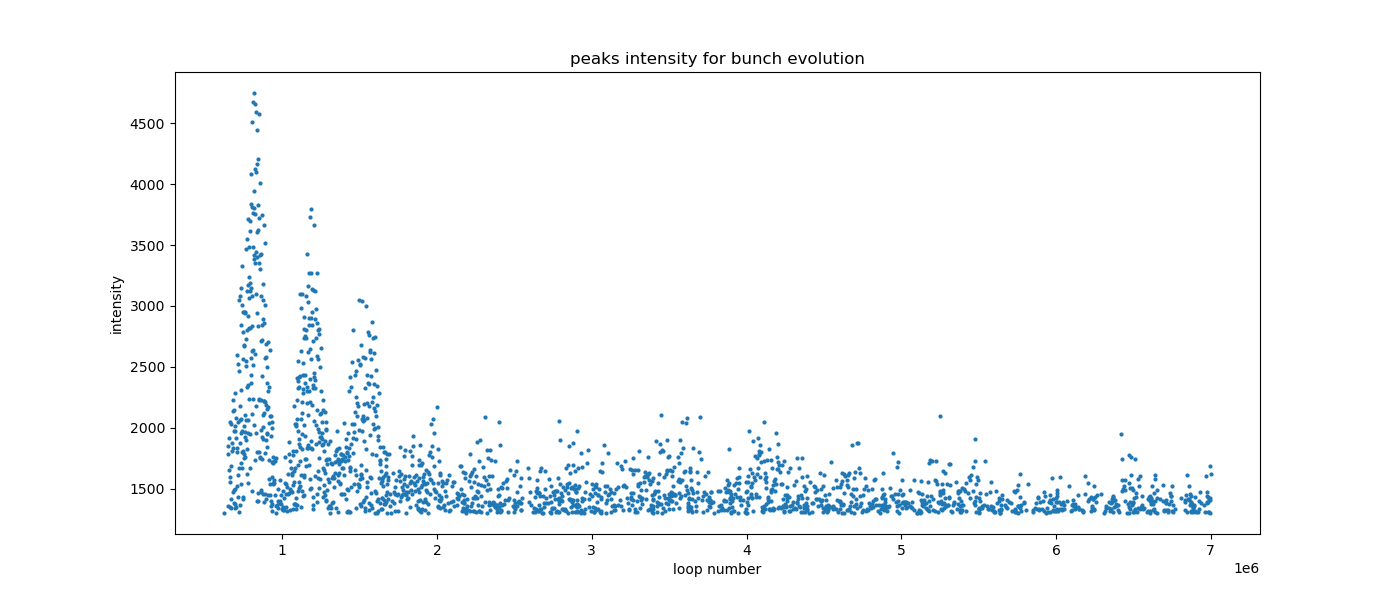

In [23]:
plt.figure(figsize=(14,6))
plt.plot(tops_refined[1:,0], tops_refined[1:,1], marker='o', linestyle='None',markersize=2)
plt.title('peaks intensity for bunch evolution')
plt.xlabel('loop number')
plt.ylabel('intensity')
plt.show()

In [22]:
#calculate difference between peaks positions
peak_differences = []
for i in range(1, len(tops_refined)):
    diff = tops_refined[i,0] - tops_refined[i-1,0]
    peak_differences.append(diff)
    